#Fitting of SIR Model to the data derived from SIR scenario

In [241]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot

In [243]:
# parameters for fitting of sir model

%cd "/content/drive/My Drive/data"
confirmed_cases_data_SIR=pd.read_csv("SIR_Data_5_.csv")
confirmed_cases_SIR=confirmed_cases_data_SIR["Cases"].values
confirmed_cases_data_abm=pd.read_csv("cases_abm.csv")
confirmed_cases_abm=confirmed_cases_data_abm["Cases"].values
inf_to_rec_d = 1.0/4.0
delta = 1.0/5.0
inf_to_dead_p=0.16
inf_to_dead_d = 1/50
s=0.01
population =820000000
ICU_BEDS=24000


/content/drive/My Drive/data


In [0]:
def deriv(y, t, N, beta, delta, inf_to_rec_d, inf_to_dead_p, inf_to_dead_d):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - d_r_thresh(I) * inf_to_dead_d * I - (1 - d_r_thresh(I)) * inf_to_rec_d * I
    dRdt = (1 - d_r_thresh(I)) * inf_to_rec_d * I
    dDdt = d_r_thresh(I) * inf_to_dead_d * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [0]:
def d_r_thresh(t):
  return 0.6 if t*0.17 * 0.48 > ICU_BEDS else inf_to_dead_p #Hospitalisation 

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
def Model(confirmed_start, days, population, R_0_start, k, x0, R_0_end, inf_to_dead_p, inf_to_rec_d):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * inf_to_rec_d
    N = population
    
    y0 = N-confirmed_start, confirmed_start, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, inf_to_rec_d, inf_to_dead_p, inf_to_dead_d))
    S, E, I, R, D = ret.T
    R_0_over_time = [beta(i)/inf_to_rec_d for i in range(len(t))]

    return t, S, E, I, R, D, R_0_over_time

In [0]:
outbreak_shift = 0
params_init_min_max = {"R_0_start": (3, 0.1, 15), "k":(15, 10, 30), "x0": (30, 0, 45), "R_0_end": (1, 0.1, 10), "inf_to_dead_p": (0.16, 0, 1), "inf_to_rec_d": (0.32, 0.3, 0.35)}  # form: {parameter: (initial guess, minimum value, max value)}

In [0]:
days_SIR = outbreak_shift + len(confirmed_cases_SIR)
days_abm = outbreak_shift + len(confirmed_cases_abm)
if outbreak_shift >= 0:
    y_data_SIR = np.concatenate((np.zeros(outbreak_shift), confirmed_cases_SIR))
    y_data_abm = np.concatenate((np.zeros(outbreak_shift), confirmed_cases_abm))    
else:
    y_data_SIR = y_data_SIR[-outbreak_shift:]
    y_data_abm = y_data_abm[-outbreak_shift:]    
x_data_SIR = np.linspace(0, days_SIR - 1, days_SIR, dtype=int)  # x_data is just [0, 1, ..., max_days] array
x_data_abm = np.linspace(0, days_abm - 1, days_abm, dtype=int)

In [0]:
def fitter_SIR(x, R_0_start, k, x0, R_0_end, inf_to_dead_p, inf_to_rec_d):
    ret_SIR = Model(confirmed_cases_data_SIR.at[11, "Cases"], days_SIR, population, R_0_start, k, x0, R_0_end, inf_to_dead_p, inf_to_rec_d)
    return ret_SIR[5][x]

In [0]:
mod = lmfit.Model(fitter_SIR)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

{'R_0_end': 0.3413676232485514,
 'R_0_start': 2.7584555587301667,
 'inf_to_dead_p': 0.16000000000000003,
 'inf_to_rec_d': 0.32371753521779184,
 'k': 22.681536008041032,
 'x0': 17.06903340839481}

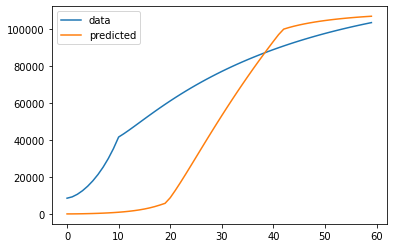

In [250]:
result = mod.fit(y_data_SIR, params, method=fit_method,  x=x_data_SIR)
#plt.plot(x_data_SIR, y_data_SIR, 'ko')
#result.plot_fit(datafmt="-");
sir_bestvalues=result.best_values

predicted_SIR = result.eval(x=x_data_SIR)   # prediction
pyplot.plot(y_data_SIR, label='data')
pyplot.plot(predicted_SIR, label='predicted')
pyplot.legend()

sir_bestvalues

In [0]:
params_init_min_max = {"R_0_start": (2.4, 0.1, 15), "k": (10, 0.01, 20.0), "x0": (10, 1, 120), "R_0_end": (2.4, 0.1, 10), "inf_to_dead_p": (0.16, 0, 1), "inf_to_rec_d": (0.2, 0.0, 1)}  # form: {parameter: (initial guess, minimum value, max value)}

In [0]:
def fitter_abm(x, R_0_start, k, x0, R_0_end, inf_to_dead_p, inf_to_rec_d):
    ret_SIR = Model(confirmed_cases_data_abm.at[0, "Cases"], days_abm, population, R_0_start, k, x0, R_0_end, inf_to_dead_p, inf_to_rec_d)
    return ret_SIR[5][x]

In [0]:
mod = lmfit.Model(fitter_abm)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

{'R_0_end': 0.6903763998947229,
 'R_0_start': 10.67957469641348,
 'inf_to_dead_p': 0.16000000000000003,
 'inf_to_rec_d': 0.20168712000334932,
 'k': 19.99999962543517,
 'x0': 9.177538495703322}

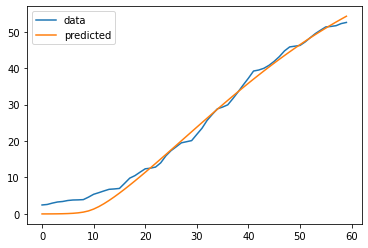

In [254]:
result = mod.fit(y_data_abm, params, method=fit_method, x=x_data_abm)
#result.plot_fit(datafmt="-")
abm_bestvalues=result.best_values
predicted_abm = result.eval(x=x_data_abm)   # prediction
y_data_abm_=np.divide(y_data_abm, 1000000)
y_data_pred_abm_=np.divide(predicted_abm, 1000000)
pyplot.plot(y_data_abm_, label='data')
pyplot.plot(y_data_pred_abm_, label='predicted')
pyplot.legend()
result.best_values

RMSE for fitting and prediction of SIR derved data
0.05216341248402698


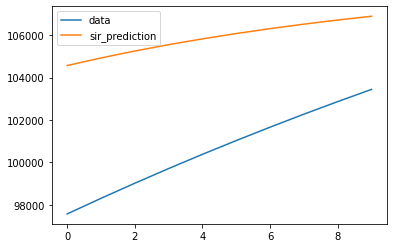

In [255]:
# comparison to the best performing timeseries prediction approach
from sklearn.metrics import mean_squared_error
from math import sqrt
def rms(y_actual, y_predicted):
  rms = sqrt(mean_squared_error(y_actual, y_predicted))
  return rms
print("RMSE for fitting and prediction of SIR derved data")
print(rms(np.log(y_data_SIR[50:61]), np.log(predicted_SIR[50:61])))
pyplot.plot(y_data_SIR[50:61], label='data')
pyplot.plot(predicted_SIR[50:61], label='sir_prediction')
pyplot.legend()

RMSE for fitting and prediction of abm derved data
0.014603294548237052


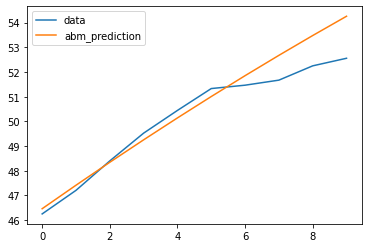

In [256]:
print("RMSE for fitting and prediction of abm derved data")
print(rms(np.log(y_data_abm[50:61]), np.log(predicted_abm[50:61])))
y_data_abm__=np.divide(y_data_abm, 1000000)
y_data_pred_abm__=np.divide(predicted_abm, 1000000)
pyplot.plot(y_data_abm__[50:61], label='data')
pyplot.plot(y_data_pred_abm__[50:61], label='abm_prediction')
pyplot.legend()

In [257]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(ICU_BEDS, t, S, E, I, R, D, R_0, x_ticks=None):
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        # ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(151)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(152)
    total_CFR = [0] + [100 * D[i] / sum(delta*E[:i]) if sum(delta*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(153)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    #sp4        
    ax4 = f.add_subplot(154)
    ax4.plot(t, I*0.17 * 0.48, 'k', alpha=0.7, linewidth=2, label='USED ICU')
    #ax4.plot(t, [ICU_BEDS for _ in range(len(I))], 'c--', alpha=0.7, linewidth=2, label='ICU CAP')
    ax4.yaxis.set_tick_params(length=0)
    ax4.xaxis.set_tick_params(length=0)
    ax4.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax4.xaxis.set_major_locator(mdates.YearLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax4.xaxis.set_minor_locator(mdates.MonthLocator())
    f.autofmt_xdate()
    legend = ax4.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    #sp5
    def d_r_calc(t):
      return 0.6 if t*0.17 * 0.48 > ICU_BEDS else inf_to_dead_p #Hospitalisation
    d_rates_over_time = [d_r_calc(t) for t in I] 
    ax5 = f.add_subplot(155)
    ax5.plot(t, d_rates_over_time, 'r', alpha=0.7, linewidth=2, label='Death_rate')
    ax5.yaxis.set_tick_params(length=0)
    ax5.xaxis.set_tick_params(length=0)
    ax5.set_ylim([0,1])
    ax5.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax5.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)            

    plt.show();

<Figure size 432x288 with 0 Axes>

Prediction with sir model


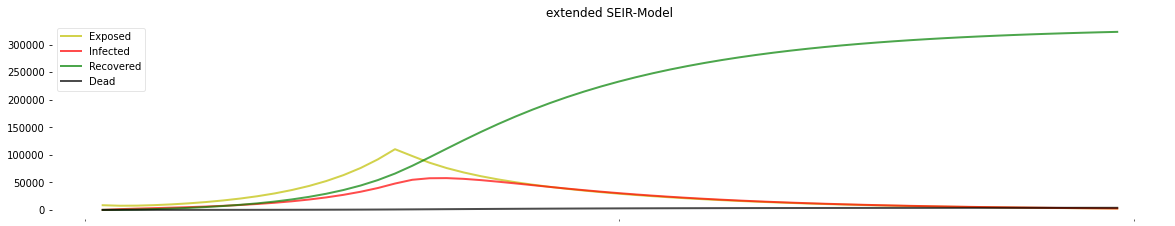

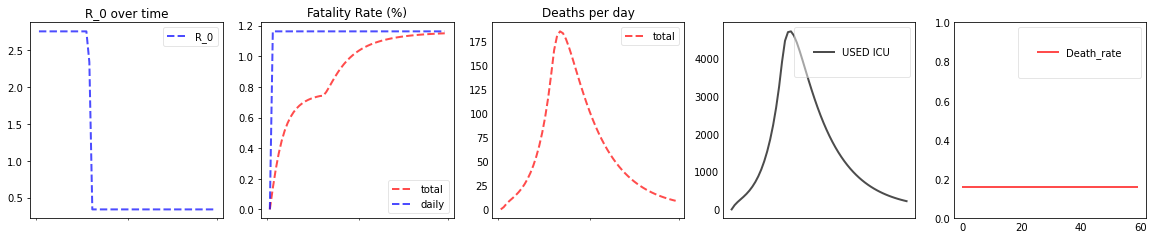

In [258]:
#prediction for 60 days using fitted sir model to sir scenarion data
full_days =60
first_date = np.datetime64(confirmed_cases_data_SIR.Date.min()) - np.timedelta64(outbreak_shift,'D')
#x_ticks = pd.date_range(start=first_date, periods=full_days, freq='D')
x_ticks = pd.date_range(start='2020-03-02', periods=full_days, freq='D')
print("Prediction with sir model")
plotter(ICU_BEDS, *Model(confirmed_cases_data_SIR.at[0, "Cases"], full_days, population, **sir_bestvalues), x_ticks=x_ticks);

Prediction with sir model


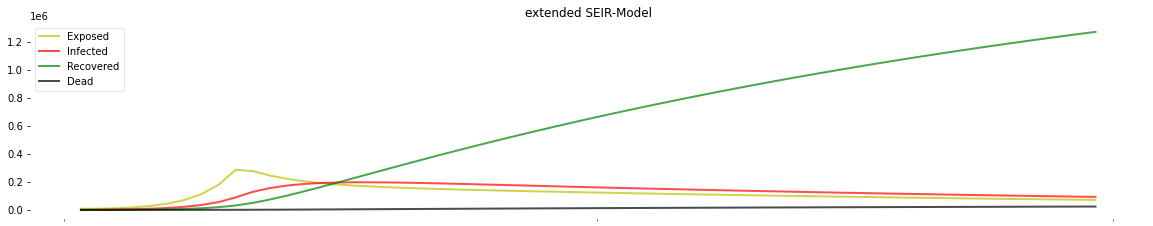

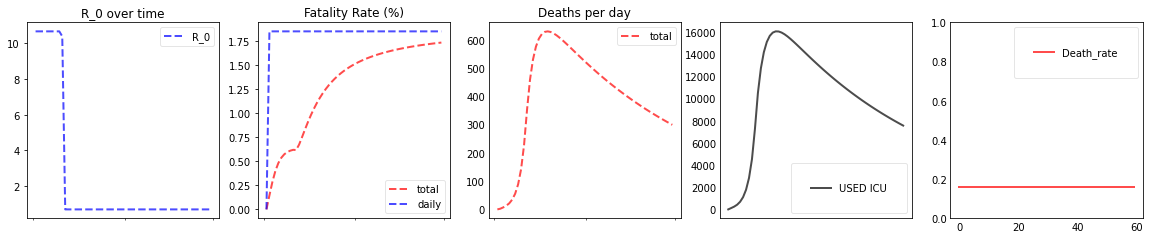

In [259]:
#prediction for 60 days using fitted sir model to abm data
full_days =60
first_date = np.datetime64(confirmed_cases_data_SIR.Date.min()) - np.timedelta64(outbreak_shift,'D')
#x_ticks = pd.date_range(start=first_date, periods=full_days, freq='D')
x_ticks = pd.date_range(start='2020-03-02', periods=full_days, freq='D')
print("Prediction with sir model")
plotter(ICU_BEDS, *Model(confirmed_cases_data_SIR.at[0, "Cases"], full_days, population, **abm_bestvalues), x_ticks=x_ticks);